# EBUS-ENSO Timeseries Analysis
- Taking output from the EBUS_extraction.py script to analyze it in coordination with Adam Phillip's CVDP output (starting with Nino 3.4)
- First step is to work with CCS, since that's a comfortable area.

In [1]:
# UNIX-style globbing
import glob

# Numerics
import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from mpl_toolkits.basemap import Basemap

import seaborn as sns
sns.set(color_codes=True)

import statsmodels.api as sm

import scipy.fftpack

# Functions
- For visibility in the Notebook

In [2]:
def detrend_nino(x):
    return signal.detrend(x)

In [3]:
def compute_correlations(carbonData, climateData):
    slope, intercept, r_value, p_value, std_err = stats.linregress(climateData, carbonData)
    return slope, r_value, r_value**2, p_value

In [4]:
def smooth_series(x, len):
    return pd.rolling_mean(x, len, center=False)

In [5]:
def drop_ensemble_dim(ds, x):
    ds[x] = (('nlat','nlon'), ds[x][0])
    return ds

In [6]:
def setup_map(ax, lon, lat):
    m = Basemap(projection='eqdc',
                lat_0=np.nanmedian(lat),
                lon_0=np.nanmedian(lon),
                llcrnrlon=np.nanmin(lon),
                urcrnrlon=np.nanmax(lon),
                llcrnrlat=np.nanmin(lat),
                urcrnrlat=np.nanmax(lat),
                resolution='c')
    m.drawcoastlines()
    #m.fillcontinents(color='black')
    m.drawmapboundary(fill_color='white')
    m.drawparallels(np.arange(np.floor(np.nanmin(lat)), 
                              np.ceil(np.nanmax(lat)), 3),
                   labels=[True,False,False,False])
    m.drawmeridians(np.arange(np.floor(np.nanmin(lon)), 
                              np.ceil(np.nanmax(lon)), 3),
                   labels=[False, False, False, False])
    return m

In [7]:
def chavez_bounds(x):
    if x == "CalCS":
        lat1 = 34
        lat2 = 44
    elif x == "CanCS":
        lat1 = 12
        lat2 = 22
    elif x == "BenCS":
        lat1 = -28
        lat2 = -18
    elif x == "HumCS":
        lat1 = -16
        lat2 = -6
    else:
        raise ValueError('\n' + 'Must select from the following EBUS strings:'
                         + '\n' + 'CalCS' + '\n' + 'CanCS' + '\n' + 'BenCS' +
                         '\n' + 'HumCS')
    return lat1, lat2

# Filter Region

In [8]:
fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/FG_CO2/BenCS/'
ds = xr.open_mfdataset(fileDir + '*.nc', concat_dim='ensemble')

In [9]:
# Reduce ensemble dimension for coordinates.
ds = drop_ensemble_dim(ds, 'DXT')
ds = drop_ensemble_dim(ds, 'TAREA')
ds = drop_ensemble_dim(ds, 'REGION_MASK')
ds = drop_ensemble_dim(ds, 'TLAT')
ds = drop_ensemble_dim(ds, 'TLONG')
del ds['DYT']
del ds['ANGLET']
# Convert DXT to kilometers.
ds['DXT'] = ds['DXT'] / 100 / 1000

In [10]:
# Filter out latitude 
lat1, lat2 = chavez_bounds("BenCS")
ds = ds.where(ds['TLAT'] >= lat1).where(ds['TLAT'] <= lat2)

In [11]:
# Create a masked array for DXT since it doesn't follow the same NaN structure.
co2 = ds['FG_CO2'][0,0]
co2 = np.ma.array(co2, mask=np.isnan(co2))
dxt_dat = ds['DXT']
dxt_dat= np.ma.array(dxt_dat, mask=np.isnan(co2))
ds['DXT'] = (('nlat','nlon'), dxt_dat)

In [12]:
# Filter out rows without a coastline to reference.
regmask = ds['REGION_MASK']
counter = 0 
for row in regmask:
    conditional = 0 in row.values
    if conditional == False:
        ds['DXT'][counter, :] = np.nan
    counter += 1

In [13]:
# Now create new variable for dist2coast
x = ds['DXT'].values
x = np.ma.array(x, mask=np.isnan(x))
dxt_cum = np.cumsum(x[:, ::-1], axis=1)[:, ::-1]
ds['DXT_Cum'] = (('nlat','nlon'), dxt_cum)

In [14]:
# Filter within 800km of coastline.
ds = ds.where(ds['DXT_Cum'] <= 800)

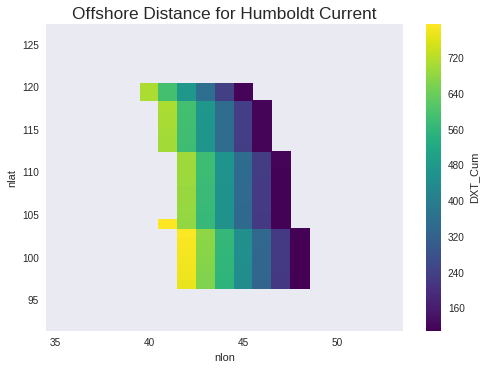

In [15]:
ds['DXT_Cum'].plot()
plt.title('Offshore Distance for Humboldt Current', size='x-large')
#plt.savefig('humboldt-current-DXT-Cum.eps')

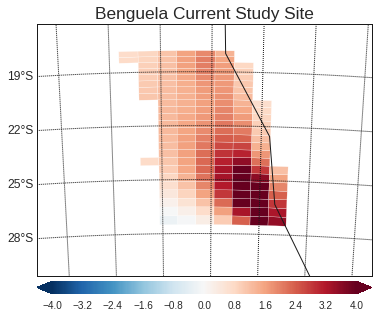

In [29]:
lon = ds['TLONG'].values
lat = ds['TLAT'].values
data = ds['FG_CO2'][0].mean(dim='time')
data = np.ma.array(data, mask=np.isnan(data))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
m = setup_map(ax,lon,lat)
m.pcolor(lon, lat, data, vmin=-4, vmax = 4,
          latlon=True, cmap="RdBu_r", edgecolors='white')
m.colorbar(location='bottom', extend='both')
plt.title('Benguela Current Study Site', size="x-large")
#plt.savefig('benguela-current-study-site.png')

# Residuals Plotting
Create a residuals dataset from the above and compare it to climate data

In [30]:
ds_residuals = ds['FG_CO2'] - ds['FG_CO2'].mean(dim='ensemble')

In [31]:
# Area-weighting
ds_residuals = ((ds_residuals * ds['TAREA']).sum(dim='nlat').sum(dim='nlon'))/ds['TAREA'].sum()

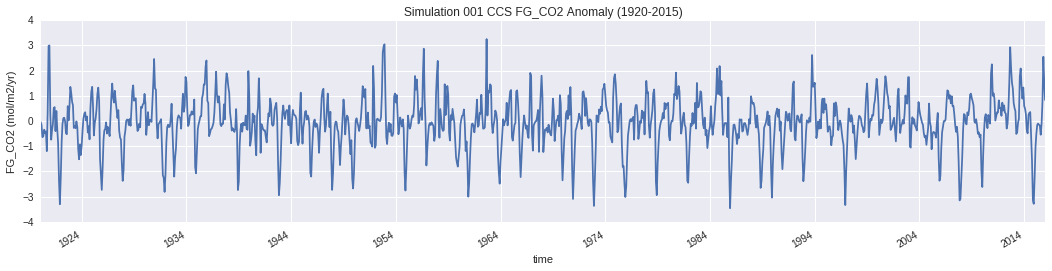

In [32]:
fig = plt.figure(figsize=(18,4))
ds_residuals[0].plot()
plt.ylabel('FG_CO2 (mol/m2/yr)')
plt.title('Simulation 001 CCS FG_CO2 Anomaly (1920-2015)')
#plt.savefig('ccs-unfiltered-fgco2-series-example.eps')
#plt.savefig('ccs-unfiltered-fgco2-series-example.png')
# NOTE: The raw time series is super noisy. Correlations are hard with something like this!

In [33]:
data = ds_residuals[0].values
hann = np.hanning(len(data))

In [34]:
Y = np.fft.fft(hann*data)

In [35]:
N = len(Y)/2+1

In [36]:
fa = 1.0/(30*24*60*60) # Sampled once every month
print('fa=%.10fHz (Frequency)' % fa)
X = np.linspace(0, fa/2, N, endpoint=True)

fa=0.0000003858Hz (Frequency)


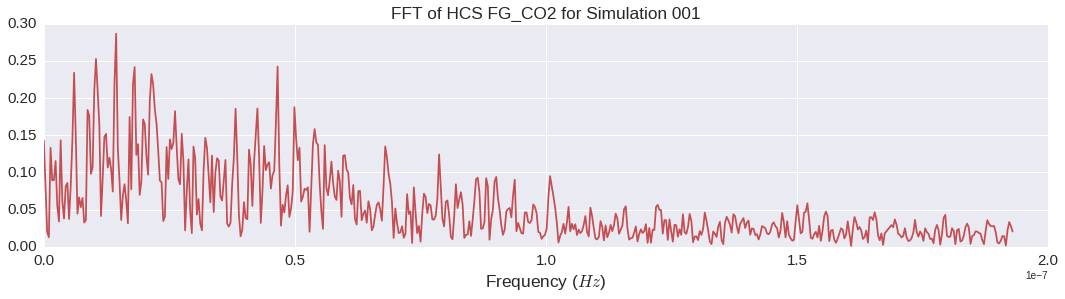

In [37]:
fig = plt.figure(figsize=(18,4))
plt.plot(X, 2.0*np.abs(Y[:N])/N, color='r')
plt.xlabel('Frequency ($Hz$)', size='x-large')
plt.title('FFT of HCS FG_CO2 for Simulation 001', size='x-large')
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.savefig('fft-HCS-001-frequencyHz.png')
# This is in frequency; want it more readable in period.

In [38]:
data = ds_residuals[0].values
smoothed_data = smooth_series(data, 12)

/glade/u/apps/opt/jupyter/5.0.0/gnu/4.8.2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  


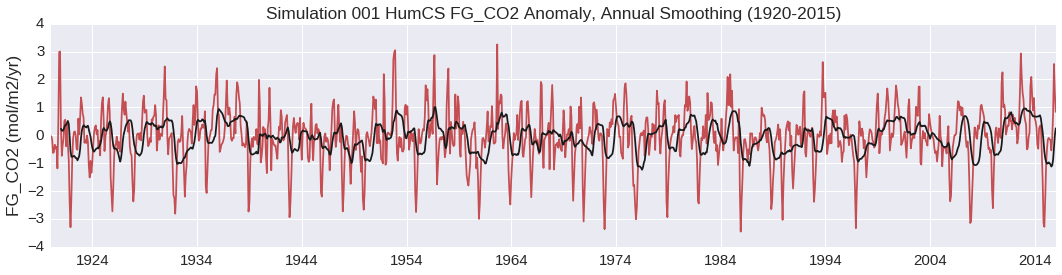

In [39]:
fig = plt.figure(figsize=(18,4))
t = ds_residuals['time'].values
plt.plot(t, data, '-r')
plt.plot(t, smoothed_data, '-k')
plt.ylabel('FG_CO2 (mol/m2/yr)', size='x-large')
plt.title('Simulation 001 HumCS FG_CO2 Anomaly, Annual Smoothing (1920-2015)', size='x-large')
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.savefig('hcs-filtered-fgco2-series-example.png')

# CVDP -- Adam Phillips
- Messing with the climate diagnostics that Adam Phillips provides

In [ ]:
fileDir = '/glade/p/work/rbrady/cesmLE_CVDP/extracted_vars/'
ds_cvdp = xr.open_mfdataset(fileDir + '*.nc', decode_times=False, concat_dim='ensemble')

In [ ]:
ds_cvdp = ds_cvdp.rename({'npo_pc_mon': 'npo', 'pdo_timeseries_mon': 'pdo'})

In [ ]:
times = pd.date_range('1920-01', '2016-01', freq='M')
ds_cvdp['time'] = times

In [ ]:
ds_cvdp = ds_cvdp.apply(detrend_nino)
ds_cvdp

In [ ]:
data = ds_residuals[10].values

In [ ]:
smoothed_data = smooth_series(data, 12)

In [ ]:
fig = plt.figure(figsize=(18,4))
nino_dat = ds_cvdp['nino34'][10]
t = nino_dat.time.values
pos = nino_dat.where(nino_dat > 0)
neg = nino_dat.where(nino_dat < 0)

ax1 = fig.add_subplot(111)
ax1.bar(t, pos, color='none', edgecolor='red')
ax1.bar(t, neg, color='none', edgecolor='blue')
ax1.set_ylabel('Nino 3.4 Index')

ax2 = ax1.twinx()
ax2.plot(t, smoothed_data, '-k')
ax2.set_ylabel('FG_CO2 Anomalies (mol/m2/yr)')

ax1.grid('off')
ax2.grid('off')

plt.title('Simulation 001 Nino3.4 Index + Smoothed FG_CO2 Anomalies')
fig.savefig('ccs-smoothed-fgco2-and-nino34-plot.png')
fig.savefig('ccs-smoothed-fgco2-and-nino34-plot.eps')


# Seaborn Jointplot

In [ ]:
ts1 = ds_residuals[32].values
ts1 = smooth_series(ts1, 12)
ts1 = ts1[11::]
ts2 = ds_cvdp['nino34'][32, 11::].values

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ts2, ts1)
r_value

In [ ]:
df = pd.DataFrame({'Nino3.4': ts2,
                   'FG_CO2': ts1})
fig = plt.figure(figsize=(6,6))
with sns.axes_style("white"):
    sns.jointplot(x='Nino3.4', y='FG_CO2', data=df,
                 kind='reg', space=0, color='k')